# Introduction to fitting spectral data
This Notebook will give a basic introduction to peak fitting of scattering spectra using the Diamond fitting scripts.
Some example spectra can be found in the exaxmple files folder and will be used here to demonstrate the various functions of the scripts.

The scripts use the lmfit package to do the actual fitting: https://lmfit.github.io/.

#### Import packages

Here we import the fitting functions from the diamond_functions file.

In [1]:
%matplotlib inline

import sys
sys.path.append('./..')

import spectrum_fitting
from spectrum_fitting import PeakParams, MaximumParams

## Analysing a single diffraction pattern

In this analysis we specify that an XRD experiment produces a **diffraction pattern**
$$I = f(\chi, 2\theta)$$
where $I$ is beam intensity, $\chi$ is the azimuthal angle and $2\theta$ is the scattering angle. The intensity is measured at a discreet number of azimuthal angles which results in the pattern being made up of a number of sectors which we call **cakes** (like a slice of cake).

<img src="images/cake_numbering.svg" alt="Illustration of cake numbering" title="Illustration of cake numbering" width="300" />
    
The cakes are ordered clockwise in the source data files but no information is provided about the location of the first cake. By convention the first cake in the data file is at the "East" position, 90&deg; clockwise from vertical. However, depending on how your data was captured this may be different for your dataset and so when loading data you must provide the angle of the first cake as a parameter. This is given in degrees clockwise from vertical.

In [2]:
first_cake_angle = 90

A **spectrum** is a scan of intensity at a set azimuthal angle (cake) across a range of two theta angles.
A **spectrum** can have one or more **peaks** in intensity which are group of one or more **maxima**. A singlet peak has one maximum, a doublet peak has two maxima etc. This distinction is important to understanding how the fits work and what parameters to provide.

We start by analysing a single file which contains a single diffraction pattern.

First we define the path to the file to be analysed:

In [3]:
file_path = '../example_data/adc_041_7Nb_NDload_700C_15mms_00001.dat'

To fit the peaks in a spectrum, the diffraction pattern must first be loaded into a `FitSpectrum` object. The data for the whole diffraction pattern is stored in the instance of the object. In this case we name our instance *spectral_data*.

In [4]:
spectral_data = spectrum_fitting.FitSpectrum(file_path, first_cake_angle)

Diffraction pattern successfully loaded from file.


A confirmation message is shown when the data is loaded.

We can then use the `plot_polar` method to plot the entire diffraction pattern:

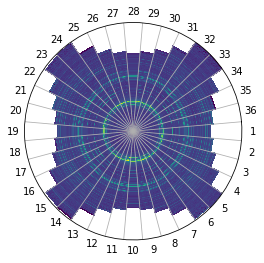

In [5]:
spectral_data.plot_polar()

The diffraction pattern is plotted with the cake number specfied next to each segment. In the example data file we have used there are 36 cakes. The number is again dependent on how the user captured the data. The number of cakes in your dataset is determined autmatically from the number of columns in the input dataset. The plot_polar command automatically adjusts shows the correct number of cakes and cake numbers according to the data file and first cake angle specified.


In order to plot a spectrum of intensity against $2\theta$ at a particular azimuthal angle use the `plot` method, specifying which cake to plot.

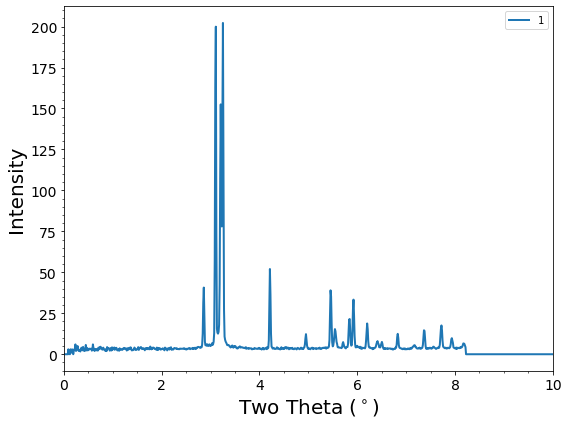

In [6]:
spectral_data.plot(1)

If you are using the an interactive matplotlib backend then it should be possible to zoom and pan the graph directly.
If you are using a non-interactive backend then you can specify the x-axis limits by passing these to the `plot` 
method.

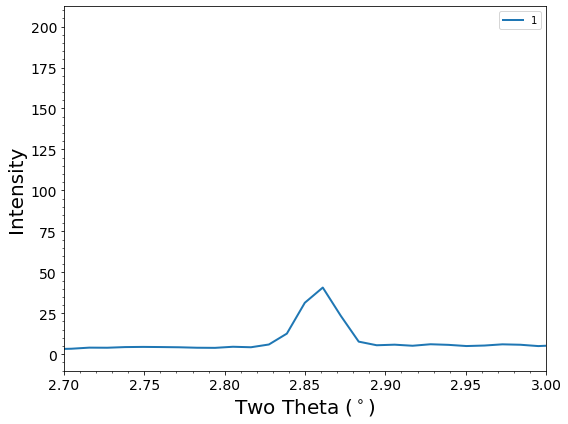

In [7]:
spectral_data.plot(1, 2.7, 3)

### Fitting a single peak from a single cake

First we consider fitting single cakes. We will cover combining data from multiple cakes later.

To begin a fit, we need to define the peak name and peak bounds. The peak name is a unique peak identifier used to refer to the peak and the peak bounds specify where the peak is in the spectrum. We provide this data by initalising a `PeakParams` object. Lets begin by fitting the above peak in the range 2.8 to 2.9.

In [8]:
peak_params = PeakParams('(10-10)', (2.8, 2.9))

Because the peak is only a singlet peak we do not need to provide any fitting parameters. The fitting is able to automatically fit the maximum in a singlet peak without help. 

The method `fit_peaks` fits the specified peaks. We need to specify the number of the cake we want to fit (in this case cake 1) and the peak params we specfied above.

In [9]:
spectral_data.fit_peaks(1, peak_params)

Fitting complete.


The results of the fit are stored in a `PeakFit` object which is stored in `FitSpectrum` object (this instance of FitSpectrum is called *spectral_data*). The Fit parameters can be viewed by using the vlaues parameter of the `PeakFit` object.

In [10]:
spectral_data.fitted_peaks[0].result.values

{'peak_1_amplitude': 1.0648217384015608,
 'peak_1_center': 2.858859789479215,
 'peak_1_sigma': 0.013478610452251013,
 'peak_1_fraction': 0.027782856828501346,
 'peak_1_fwhm': 0.026957220904502026,
 'peak_1_height': 36.775851273729636,
 'constant_background': 4.59166065314623}

To get a peak by name we can use the `get_fit` method of the `FitSpectrum` object.

In [11]:
spectral_data.get_fit("(10-10)").result.values

{'peak_1_amplitude': 1.0648217384015608,
 'peak_1_center': 2.858859789479215,
 'peak_1_sigma': 0.013478610452251013,
 'peak_1_fraction': 0.027782856828501346,
 'peak_1_fwhm': 0.026957220904502026,
 'peak_1_height': 36.775851273729636,
 'constant_background': 4.59166065314623}

values is just a Python dictionary so individual values can be subscripted as normal, for example the peak centre is:

In [12]:
spectral_data.get_fit("(10-10)").result.values['peak_1_center']

2.858859789479215

Full details on the fit can be seen by querying the `result` object dirrectly. This is an LMFIT ModelResult object - further documentation can be found at https://lmfit.github.io/lmfit-py/model.html#the-modelresult-class

In [13]:
spectral_data.get_fit("(10-10)").result

There is also a method for plotting the fit:

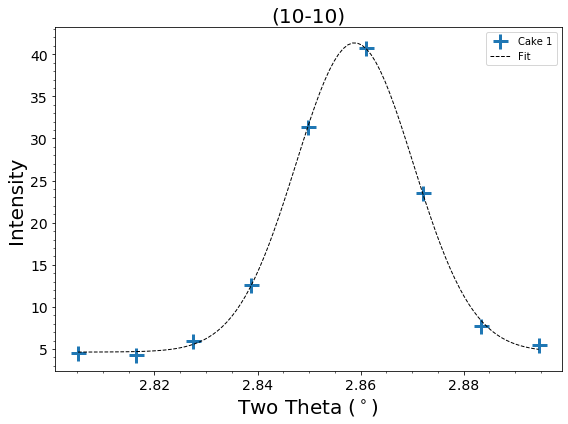

In [14]:
spectral_data.get_fit("(10-10)").plot()

For peaks with a single maxima we normally don't need to specify any fitting parameters - the algorithm can fit the peaks 
on its own using default values. If the fitting of a singlet peak fails for any reason, we can provide the fitting algorithm with parameters to improve this fit. We specify fitting parameters using a `MaximumParams` object. By default the `PeakParams` object is loaded with a single default instance of `MaximumParams`. This means that the command:

`peak_params = PeakParams('(10-10)', (2.8, 2.9))`

is equivalent to:

`peak_params = PeakParams('(10-10)', (2.8, 2.9), MaximumParams())`

By loading `MaximumParams` with no parameters, the default fitting values are used. If we wanted to be even more specific the command

`peak_params = PeakParams('(10-10)', (2.8, 2.9), MaximumParams(2.86, 2.84, 2.88))`

will also give the same fit as the above two commands. Specifying `MaximaParams` is described in more detail in the section below about fitting doublet peaks.

### Fitting multiple peaks simultaneously

It can be more convinient to specify multiple peaks and fit them all at once. Here we try to fit the first 4 peaks in the spectrum at once. First get a good zoomed in view to see where the peaks are:

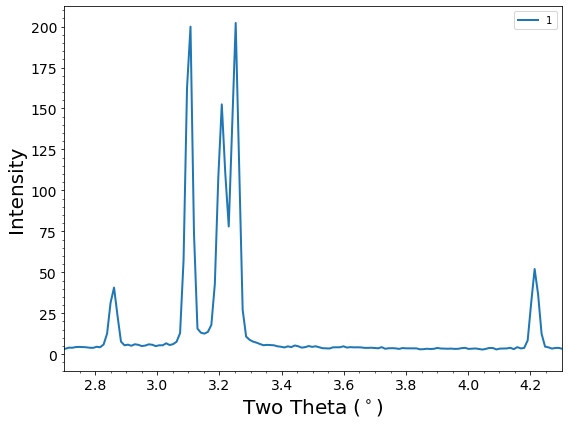

In [15]:
spectral_data.plot(1, 2.7, 4.3)

By providing a list of `PeakParams`, we can fit multiple peaks simultaneously.

Fitting complete.


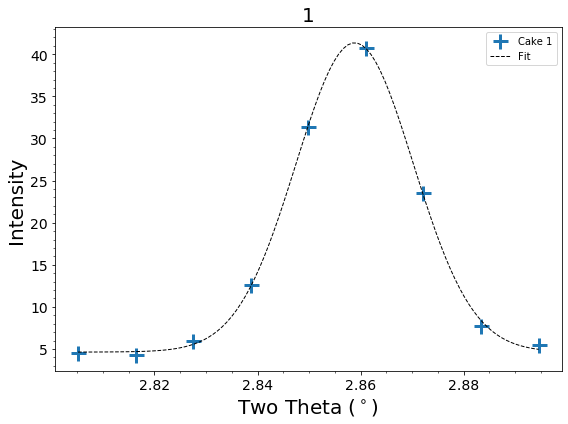

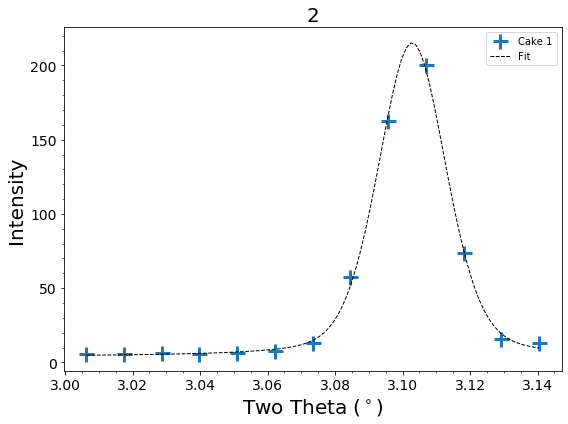

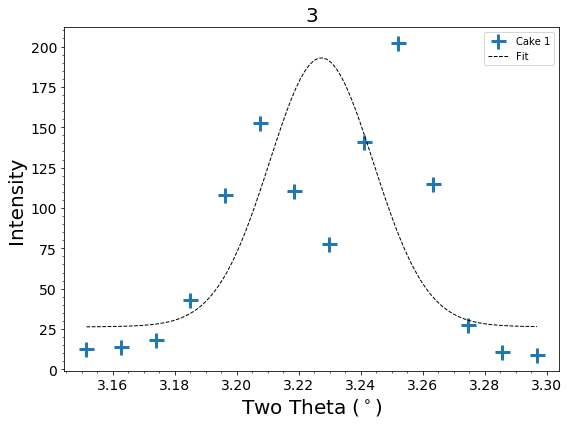

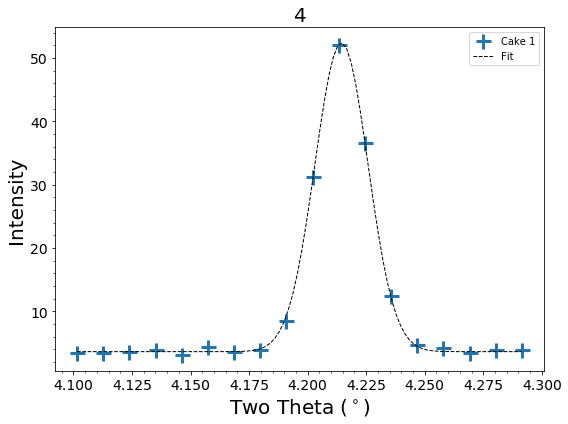

In [16]:
peak_params = [PeakParams('1', (2.8, 2.9)), PeakParams('2', (3.0, 3.15)), 
               PeakParams('3', (3.15, 3.3)), PeakParams('4', (4.1, 4.3))]
spectral_data.fit_peaks(1, peak_params)

for fit in spectral_data.fitted_peaks:
    fit.plot()

Note that the third peak is a doublet peak with two maxima and is fitted very poorly. This is becuase unless we tell it, the fitting cannot guess that it is a doublet peak and so tries to fit it as a single maxima. 
Fitting doublet peaks like the one in the range (3.15, 3.3) requires a little more information.

First lets zoom in to get a better view of the peak

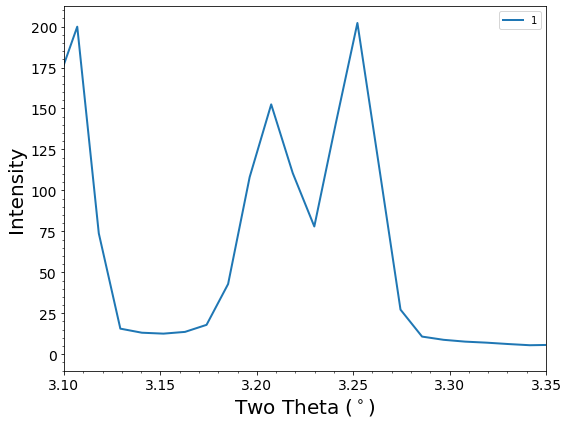

In [17]:
spectral_data.plot(1, 3.1, 3.35)

In order to tell the fitting algorithm to fit two maxima we need to provide one `MaximumParams` object for each maximum. In addition, because the maxima are close, the algorithm struggles to pick them out individually so we need to manually provide some fitting parameters to each `MaximumParams` object. `MaximumParams` takes the parameters, *center*, *min* and *max* to describe the position of the maximum. *center* is the approximate center point of the maximum and *min* and *max* are upper and lower bounds for the center of the maximum. The fitting algorithm will try a range of values between *min* and *max*.

In summary, to fit a peak with more than one maximum, we must provide a `PeakParams` object with one `MaximumParams` for each maximum in the peak.

Fitting complete.


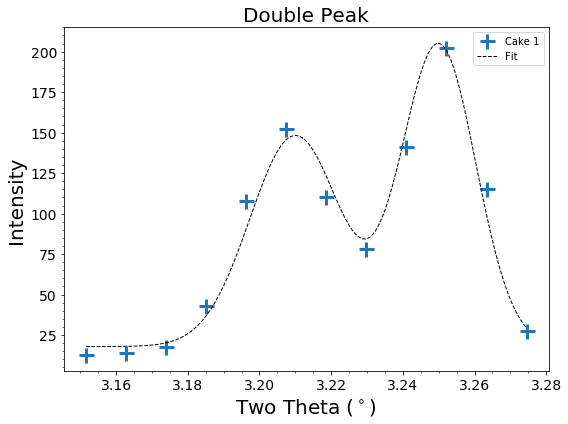

In [18]:
peak_params = PeakParams('Double Peak', (3.15, 3.28), [MaximumParams(3.16, 3.21, 3.23), MaximumParams(3.23, 3.25, 3.28)])

spectral_data.fit_peaks(1, peak_params)
spectral_data.get_fit('Double Peak').plot()

We can combine these seamlessly to fit the single and doublet peaks at the same time. Going back to the above example, we can fit the
first 4 peaks in the spectrum like this:

Fitting complete.


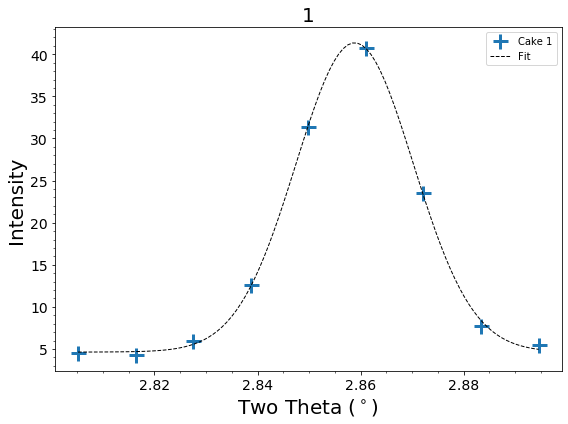

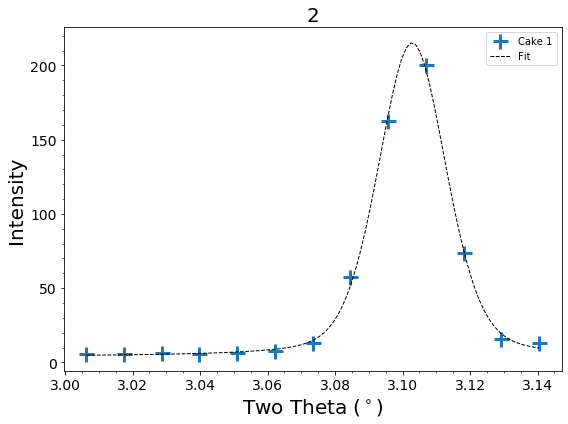

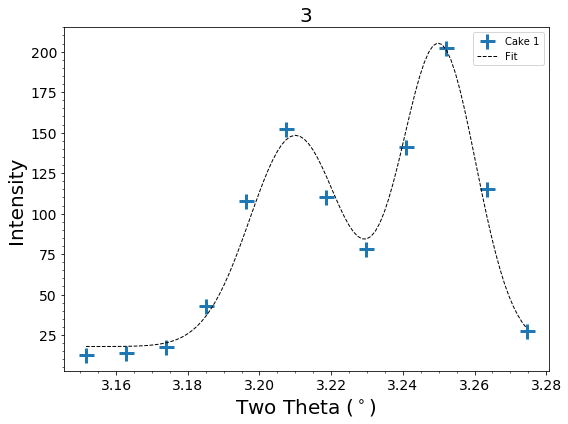

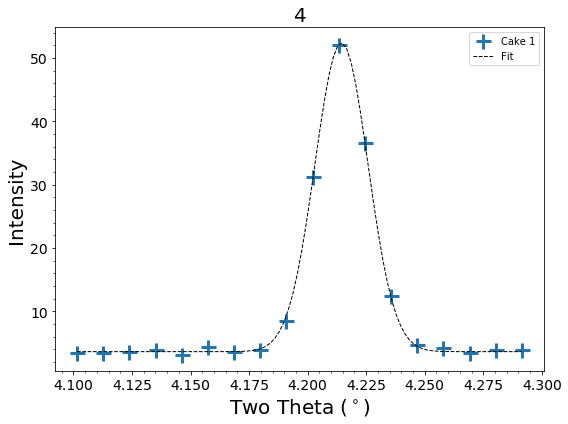

In [19]:
peak_params = [PeakParams('1', (2.8, 2.9)),
               PeakParams('2', (3.0, 3.15)),
               PeakParams('3',  (3.15, 3.28), [MaximumParams(3.16, 3.21, 3.23), MaximumParams(3.23, 3.25, 3.28)]),
               PeakParams('4', (4.1, 4.3))]
spectral_data.fit_peaks(1, peak_params)

for fit in spectral_data.fitted_peaks:
    fit.plot()

This now fits all of the peaks appropriately.